In [305]:
import tensorflow as tf
from tensorflow import keras
from random import shuffle
import numpy as np
import csv

In [306]:
dict = {
    0: "Rock",
    1: "Paper",
    2: "Scissors"
}

In [307]:
player_sequences = []
computer_sequences = []
win_data = []

labels = []

maxlen = 5
split = 0.65

with open('../../data/temp.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)

    next(reader)

    for row in reader:
        inputs = [int(char) for char in row[2]]
        for i in range(1, len(inputs)+1):
            player_sequences.append(inputs[:i+1])
        inputs = [int(char) for char in row[4]]
        for i in range(1, len(inputs)+1):
            computer_sequences.append(inputs[:i+1])
        inputs = [(lambda x : 2 if x=='w' else (1 if x=='t' else -4))(char) for char in row[3]]
        for i in range(1, len(inputs)+1):
            win_data.append(inputs[:i+1])

# s = '2002120021200212002120021200212002120021200212002120021200212002120021200212002120021200212002120021'
# input = [int(i) for i in s]
# for i in range(1, len(input)+1):
#     player_sequences.append(input[:i+1])


In [308]:
np.shape(player_sequences), np.shape(computer_sequences), np.shape(win_data)

((494,), (494,), (494,))

In [309]:
player_sequences = list(filter(lambda x : len(x) >= maxlen+1,player_sequences))
computer_sequences = list(filter(lambda x : len(x) >= maxlen+1, computer_sequences))
win_data = list(filter(lambda x : len(x) >= maxlen+1, win_data))

In [310]:
player_sequences = list(map(lambda x: x[-maxlen-1:], player_sequences))
computer_sequences = list(map(lambda x: x[-maxlen-1:], computer_sequences))
win_data = list(map(lambda x: x[-maxlen-1:], win_data))

In [311]:
player_sequences[:5], computer_sequences[:5], win_data[:5]

([[1, 2, 1, 1, 1, 2],
  [2, 1, 1, 1, 2, 3],
  [1, 1, 1, 2, 3, 2],
  [1, 1, 2, 3, 2, 1],
  [1, 2, 3, 2, 1, 2]],
 [[3, 1, 3, 1, 2, 2],
  [1, 3, 1, 2, 2, 1],
  [3, 1, 2, 2, 1, 3],
  [1, 2, 2, 1, 3, 3],
  [2, 2, 1, 3, 3, 3]],
 [[2, 2, 2, 1, -4, 1],
  [2, 2, 1, -4, 1, -4],
  [2, 1, -4, 1, -4, -4],
  [1, -4, 1, -4, -4, 2],
  [-4, 1, -4, -4, 2, -4]])

In [312]:
player_sequences, computer_sequences, win_data = np.array(player_sequences), np.array(computer_sequences), np.array(win_data)

In [313]:
player_inputs, labels = player_sequences[:,:-1], player_sequences[:,-1]
computer_inputs = computer_sequences[:,:-1]
win_inputs = win_data[:,:-1]

In [314]:
np.shape(player_inputs), np.shape(computer_inputs), np.shape(win_inputs)

((490, 5), (490, 5), (490, 5))

In [315]:
player_inputs[:5], computer_inputs[:5], win_inputs[:5]

(array([[1, 2, 1, 1, 1],
        [2, 1, 1, 1, 2],
        [1, 1, 1, 2, 3],
        [1, 1, 2, 3, 2],
        [1, 2, 3, 2, 1]]),
 array([[3, 1, 3, 1, 2],
        [1, 3, 1, 2, 2],
        [3, 1, 2, 2, 1],
        [1, 2, 2, 1, 3],
        [2, 2, 1, 3, 3]]),
 array([[ 2,  2,  2,  1, -4],
        [ 2,  2,  1, -4,  1],
        [ 2,  1, -4,  1, -4],
        [ 1, -4,  1, -4, -4],
        [-4,  1, -4, -4,  2]]))

In [316]:
decay = 0.6
test_xs = player_inputs - 1
test_xs = keras.utils.to_categorical(test_xs, num_classes=3)

apply_decay = lambda x : np.array([x[j]*(decay**(len(x) - j - 1)) for j in range(len(x))])

for i in range(len(test_xs)):
    test_xs[i] = apply_decay(test_xs[i])

test_xs.shape

(490, 5, 3)

In [317]:
final_xs = np.array([np.array([test_xs[i,j] * win_inputs[i,j] for j in range(maxlen)]) for i in range(len(test_xs))])
final_xs.shape

(490, 5, 3)

In [318]:
final_xs = np.sum(final_xs, axis=1)
final_xs.shape

(490, 3)

In [319]:
final_labels = labels - 1
final_labels = keras.utils.to_categorical(final_labels, num_classes=3)

In [320]:
final_xs[:5], final_labels[:5]

(array([[-2.4208    ,  0.432     ,  0.        ],
        [-1.608     ,  1.2592    ,  0.        ],
        [-0.96480006,  0.6       , -4.        ],
        [-0.73440003, -3.6399999 , -2.4       ],
        [ 1.4816    , -2.184     , -1.44      ]], dtype=float32),
 array([[0., 1., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [1., 0., 0.],
        [0., 1., 0.]], dtype=float32))

In [321]:
train_size = int(split * len(final_xs))
valid_size = int(((1+split)/2) * len(final_xs))

training_data, training_labels = final_xs[:train_size], final_labels[:train_size]
valid_data, valid_labels = final_xs[train_size:valid_size], final_labels[train_size:valid_size]
test_data, test_labels = final_xs[valid_size:], final_labels[valid_size:]

In [322]:
print(f"Training data: {training_data.shape}, {training_labels.shape}")
print(f"Validation data: {valid_data.shape}, {valid_labels.shape}")
print(f"Test data: {test_data.shape}, {test_labels.shape}")

Training data: (318, 3), (318, 3)
Validation data: (86, 3), (86, 3)
Test data: (86, 3), (86, 3)


In [323]:
model = tf.keras.Sequential([
    # tf.keras.layers.LSTM(160, input_shape=(input_dim, maxlen), return_sequences=True),
    # tf.keras.layers.LSTM(160, return_sequences=True),
    # tf.keras.layers.LSTM(160),
    
    tf.keras.layers.Dense(160, activation='relu', input_shape= (3,)),
    # tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [324]:
optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

In [325]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [326]:
history = model.fit(training_data, training_labels, epochs=250, batch_size=16, verbose=1, shuffle=True, validation_data=(valid_data, valid_labels))

Epoch 1/250
20/20 [==============================] - 1s 16ms/step - loss: 1.1656 - accuracy: 0.2925 - val_loss: 1.1624 - val_accuracy: 0.3023
Epoch 2/250
20/20 [==============================] - 0s 9ms/step - loss: 1.1345 - accuracy: 0.3050 - val_loss: 1.1338 - val_accuracy: 0.3140
Epoch 3/250
20/20 [==============================] - 0s 8ms/step - loss: 1.1170 - accuracy: 0.3019 - val_loss: 1.1175 - val_accuracy: 0.2791
Epoch 4/250
20/20 [==============================] - 0s 6ms/step - loss: 1.1063 - accuracy: 0.3459 - val_loss: 1.1090 - val_accuracy: 0.3605
Epoch 5/250
20/20 [==============================] - 0s 6ms/step - loss: 1.0986 - accuracy: 0.3711 - val_loss: 1.1060 - val_accuracy: 0.3372
Epoch 6/250
20/20 [==============================] - 0s 6ms/step - loss: 1.0936 - accuracy: 0.3711 - val_loss: 1.1044 - val_accuracy: 0.3605
Epoch 7/250
20/20 [==============================] - 0s 7ms/step - loss: 1.0895 - accuracy: 0.3868 - val_loss: 1.1020 - val_accuracy: 0.3488
Epoch 8/250


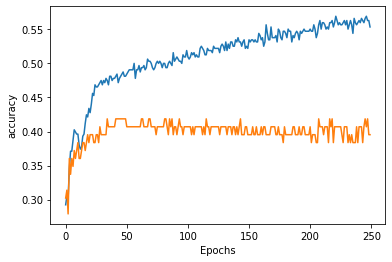

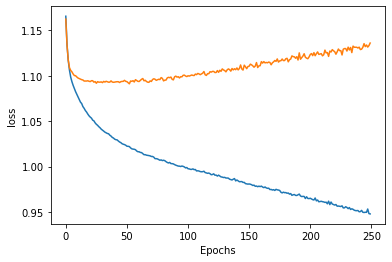

In [330]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.show()

# Visualize the accuracy
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [331]:
model.evaluate(test_data, test_labels)

3/3 [==============================] - 0s 5ms/step - loss: 1.1773 - accuracy: 0.3488


[1.177259922027588, 0.3488371968269348]

In [329]:
model.save('../models/test_lstm.h5')